In [1]:
%matplotlib nbagg

from script.model import Model, DataSet
from script.model_esn import ModelEsn
# from script.model_lstm import ModelLstm

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import threading


In [2]:
# Reservoir warmup function

def reservoir_warmup(A, Win, warmup_input, model_params, warmup_length):

    states = np.zeros((model_params['size'], warmup_length + 1))
    for i in range(warmup_length):
        a = np.dot(A, states[:, i])
        b = np.dot(Win, warmup_input[:, i])
        states[:, i + 1] = np.tanh(a + b)
    return states[:,-1]


# Delinearize reservoir state

def delinearize_array(in_arr):
    
    arr_shifted = np.insert(in_arr.copy()[:-1], 0, 1)
    arr_mult = np.multiply(in_arr, arr_shifted)
    return np.dstack((in_arr[::2], arr_mult[1:][::2])).flatten()


# Predict function

def predict_with_warmup(A, Win, model_params, warmup_input, Wout, pred_length, thread_state, warmup_length):
    
    res_state = reservoir_warmup(A, Win, warmup_input, model_params, warmup_length)
    output = np.zeros((model_params['n_inp'], pred_length))
    for i in range(pred_length):
        if thread_state['running'] == False:
            return None
        x_aug = delinearize_array(res_state)
        output[:, i] = np.squeeze(np.asarray(np.dot(Wout, x_aug)))
        x1 = np.tanh(np.dot(A, res_state) + np.dot(Win, output[:, i]))
        res_state = np.squeeze(np.asarray(x1))
    return output


In [3]:
# Plot reference data and predicted output

def plot_lines(reference_data_start, reference_data_end, reference_data, vertical_line_time,
              prediction_start_time, prediction_end_time, prediction, horizon, model_params, red_col):

    if not prediction is None and \
        ((prediction_start_time > reference_data_start and prediction_start_time < reference_data_end) or 
         (prediction_end_time > reference_data_start and prediction_end_time < reference_data_end)):

        time_skipped = prediction_start_time - model_params['tr_len']
        prediction_length = prediction_end_time - prediction_start_time

        if prediction_start_time < reference_data_start:
            left_cut = reference_data_start - prediction_start_time
            prediction_start_time += left_cut
            prediction = prediction[:, left_cut:]

        if prediction_end_time > reference_data_end:
            right_cut = prediction_end_time - reference_data_end
            prediction_end_time -= right_cut
            prediction = prediction[:, :-right_cut]
            
        plt.suptitle('ESN free prediction\nReservoir size: {}\nTraining length: {}\nTime skipped: {}\n'
                     'Prediction length: {}\nWarmup length: {}\nPrediction horizon: {}'.format(
                         model_params['size'], model_params['tr_len'], time_skipped, 
                         prediction_length, temp_params['old_warmup_size'], horizon / 200))
        
    else:
        plt.suptitle('ESN free prediction')
            
    for var in range(model_params['n_inp']):
        ax[var].clear()
        ax[var].plot(range(reference_data_start, reference_data_end), reference_data[var], 'black')
        if not prediction is None and \
            ((prediction_start_time > reference_data_start and prediction_start_time < reference_data_end) or 
             (prediction_end_time > reference_data_start and prediction_end_time < reference_data_end)):
            ax[var].plot(range(prediction_start_time, prediction_end_time), prediction[var], 
                    red_col, label='Variable = {}'.format(var + 1))
            ax[var].legend(loc=1)
            ax[var].axvline(x=vertical_line_time, color='black', linestyle='--')
            if horizon is not None:
                ax[var].axvline(x=prediction_start_time + horizon, color='black', linestyle='--')
    
        ax[var].set_ylim([-3, 3])
    plt.draw()

    
# Thread function for parallel computation of prediction output
    
def prediction_thread(A, Win, model_params, warmup_input, Wout, pred_length, thread_state,
                    reference_data_start, reference_data_end, reference_data,
                    prediction_start_time, prediction_end_time, warmup_length, graph_padding):
    
    prediction = predict_with_warmup(A, Win, model_params, warmup_input, Wout, pred_length, thread_state, warmup_length)
    if thread_state['running'] == True:
        temp_params['old_prediction'] = prediction
        temp_params['old_prediction_start'] = prediction_start_time
        temp_params['old_prediction_end'] = prediction_end_time
        
        comp_data = reference_data[:, graph_padding:graph_padding + pred_length]
        e = np.linalg.norm(prediction - comp_data, axis=0) / np.linalg.norm(comp_data, axis = 0)
        temp_params['old_horizon'] = np.argmax(e > 0.3) if (e > 0.3).any() else pred_length
        
        temp_params['old_warmup_size'] = warmup_length
        plot_lines(reference_data_start, reference_data_end, reference_data, prediction_start_time,
                   prediction_start_time, prediction_end_time, temp_params['old_prediction'],
                   temp_params['old_horizon'], model_params, 'red')
    
        temp_params['plot_thread'] = None
        

In [4]:
# Prepare the params and the model

temp_params = {}
temp_params['plot_thread'] = None
temp_params['plot_thread_state'] = None

temp_params['old_prediction'] = None
temp_params['old_prediction_start'] = None
temp_params['old_prediction_end'] = None
temp_params['old_horizon'] = None
temp_params['old_warmup_size'] = None

# Loading Lorenz data

data_set = DataSet('lorenz_96', 200, 1)
data = data_set.data

# Load default initialization parameters

model_params = Model.default_model_params('esn')
# model_params = Model.default_model_params('lstm')
run_params = Model.default_run_params()

# Load or train the model

model = ModelEsn(model_params, data_set.path_prefix())
# model = ModelLstm(model_params, data_set.path_prefix())
model.load_or_train(data, True)
predictions = np.zeros((run_params['num_i_c'], model_params['n_inp'], run_params['pred_len']))


Loading lorenz_96... Done
lorenz_96, 200, 1/8, 0, 300000, 0,1, 3, 0,5, 0,0001, 100, 200, tanh, 5000
Loading reservoir... 1
2
3
4
generating reservoir 5
Loading reservoir... Done

<IPython.core.display.Javascript object>


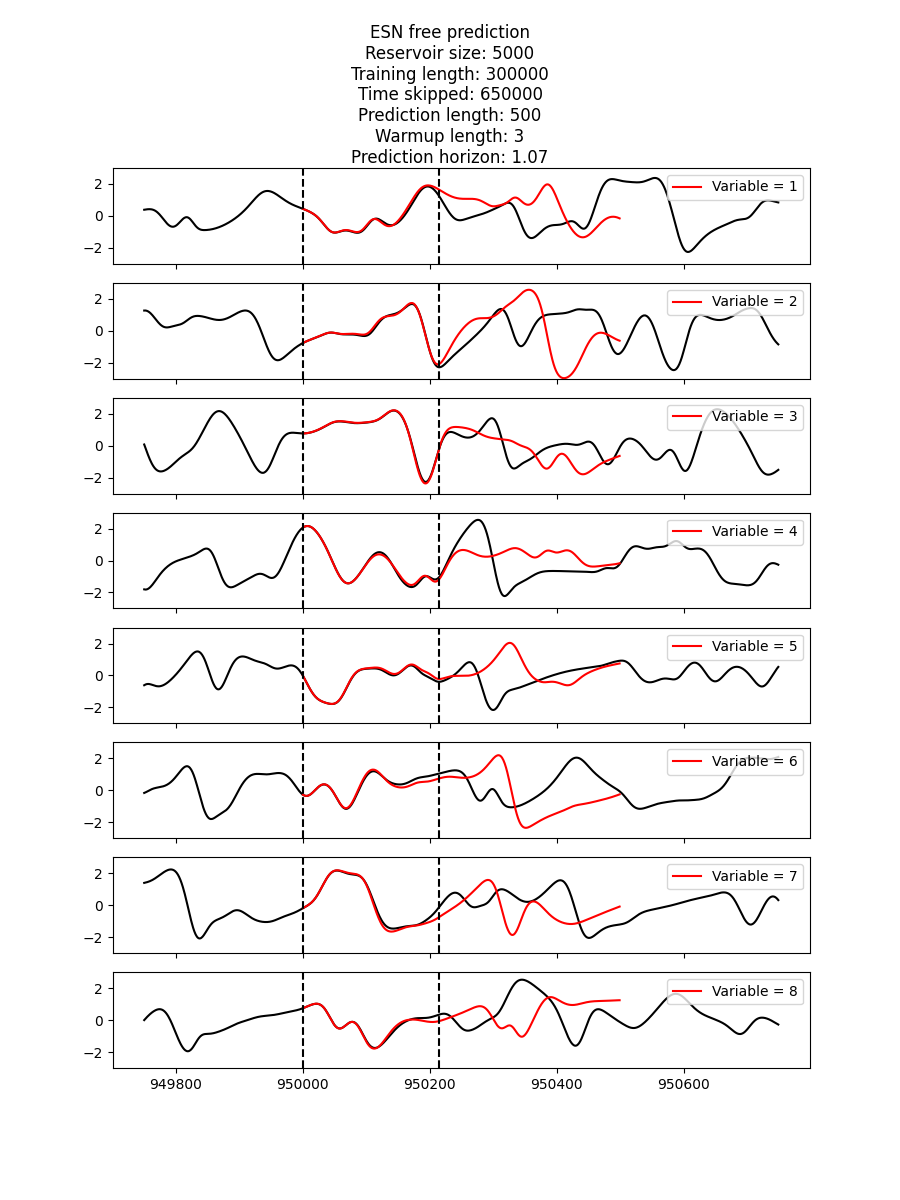

interactive(children=(IntSlider(value=950000, description='Global skip:', max=997000, min=3000, step=1000), In…

In [5]:
# Predict 

fig, ax = plt.subplots(model_params['n_inp'], figsize=(9, 1.5 * model_params['n_inp']), sharex=True)
plt.subplots_adjust(top=0.86)
plt.suptitle('ESN free prediction')
for var in range(model_params['n_inp']):
    ax[var].set_xlabel('$timestep$')
    ax[var].set_ylabel('$output$')


def update_plot(time_offset_1000, time_offset_10, pred_length, warmup_length):
    global model_params

    predict_time_offset = time_offset_1000 + time_offset_10
    prediction_start_time = predict_time_offset #  + model_params['tr_len']
    prediction_end_time = prediction_start_time + pred_length
    graph_padding = int(pred_length * 0.5)

    reference_data_start = prediction_start_time - graph_padding
    reference_data_end = prediction_end_time + graph_padding
    prediction_data_warmup_start = prediction_start_time - warmup_length

    reference_data = data[:, reference_data_start:reference_data_end]

    warmup_input = data[:, prediction_data_warmup_start:prediction_start_time]
        
    plot_lines(reference_data_start, reference_data_end, reference_data, prediction_start_time,
               temp_params['old_prediction_start'], temp_params['old_prediction_end'], temp_params['old_prediction'],
               temp_params['old_horizon'], model_params, 'lightcoral')

    # Prediction thread
    if temp_params['plot_thread'] != None:
        temp_params['plot_thread_state']['running'] = False

    temp_params['plot_thread_state'] = { 'running': True }
    temp_params['plot_thread'] = threading.Thread(
        target=prediction_thread, 
        args=(model.a, model.w_in, model_params, warmup_input, model.w_out, pred_length, temp_params['plot_thread_state'],
              reference_data_start, reference_data_end, reference_data,
              prediction_start_time, prediction_end_time, warmup_length, graph_padding)
    )
    temp_params['plot_thread'].start()


time_offset_1000 = widgets.IntSlider(
    min=3000,
    max=data.shape[1] - 3000, 
    step=1000, value=950000, 
    description='Global skip:',
    continuous_update=True)

time_offset_10 = widgets.IntSlider(
    min=0, max=1000, step=10, value=0, 
    description='Local skip:',
    continuous_update=True)

pred_length = widgets.IntSlider(
    min=100, max=1000, value=500,
    description='Pred length:',
    continuous_update=True)

warmup_length = widgets.IntSlider(
    min=1, max=10, value=3,
    description='Warmup:',
    continuous_update=False)

widgets.interactive(
    update_plot,
    time_offset_1000=time_offset_1000, 
    time_offset_10=time_offset_10, 
    pred_length=pred_length,
    warmup_length=warmup_length)
